# Facial Recognition using FaceNet:
## Can my face be recognized?
---
Fascinated by the facial recognition technology, I tested the pretrained facial recognition model [FaceNet](https://github.com/timesler/facenet-pytorch), which was trained on the [VGGFace2](https://github.com/ox-vgg/vgg_face2) dataset with my photos. I started with the examples used in Neuromatch Academy Deep Learning online summer school 2021 (I was a teaching assistant there!), and then showed you how well the model could recognize my face.

Contents
- [Section 1: Setup](#section1-setup)
- [Section 2: Data processing](#section2-data-processing)
    - [Part 1: Download and prepare the data](#part1-download-and-prepare-the-data)
    - [Part 2: View and transform the data](#part2-view-and-transform-the-data)
    - [Part 3: Embedding with a pretrained network](#part3-embedding-with-a-pretrained-network)
- [Section 3: Similarity and dissimilarity measures](#section3-similarity-and-dissimilarity-measures)
- [Section 4: Train a ResNet](#section4-train-a-model)
    - [Part 1: Data selection](#part1-data-selection)
    - [Part 2: Fine-tuning a pretrained ResNet](#part2-fine-tuning-a-pretrained-resnet)
    - [Part 3: Test with new images](#part3-test-with-new-images)
    - [Part 4: Train from scratch](#part4-train-from-scratch)

[comment]: <> (Section 5: Siamese Network)




## Section 1: Setup

In [9]:
# Install dependencies
# Install `facenet` - a model used to do facial recognition

# pip install
!pip install facenet-pytorch --quiet
!pip install Pillow --quiet

# git clone (alternative installation in HPC) 
# !git clone https://github.com/timesler/facenet-pytorch.git facenet_pytorch
# !git clone https://aur.archlinux.org/python-pillow-git.git Pillow

In [10]:
# Import packages
import glob
import torch
import tqdm

import numpy as np
import sklearn.decomposition, sklearn.manifold
import matplotlib.pyplot as plt

from PIL import Image

from torchvision import transforms
from torchvision.utils import make_grid, save_image
from torchvision.datasets import ImageFolder

from facenet_pytorch import MTCNN, InceptionResnetV1, training, fixed_image_standardization

In [11]:
# Set random seed
# Executing `set_seed(seed=seed)` you are setting the seed
# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [12]:
# Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [13]:
SEED = 2021
set_seed(seed=SEED)
device = set_device()

Random seed 2021 has been set.


---
## Section 2: Data processing
### Part 1: Download and prepare the data

In [14]:
# Download Data
import requests, zipfile, io, os

# original link: https://github.com/ben-heil/cis_522_data.git
# url = 'https://osf.io/2kyfb/download'
fname = 'faces'
url = 'https://github.com/myyim/dataset/raw/main/'+fname+'.zip'

if not os.path.exists(fname+'zip'):
  print("Data is being downloaded...")
  r = requests.get(url, stream=True)
  z = zipfile.ZipFile(io.BytesIO(r.content))
  z.extractall()
  print("The download has been completed.")
else:
  print("Data has already been downloaded.")

Data is being downloaded...
The download has been completed.


### Part 2: View and transform the data

MTCNN ([github repo](https://github.com/ipazc/mtcnn)) detects the face and crops the image around the face.

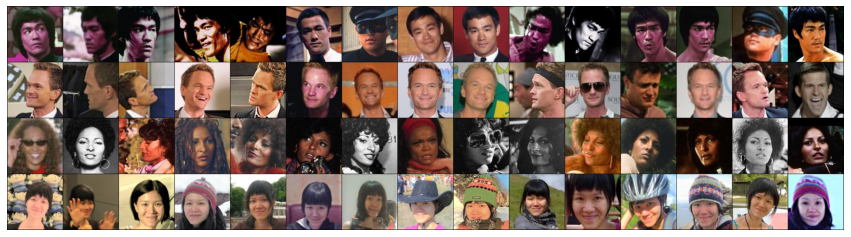

In [15]:
# Display Imaclass_to_idxges
# Here are the source images of Bruce Lee, Neil Patrick Harris, Pam Grier and me
train_transform = transforms.Compose((transforms.Resize((256, 256)),
                                      transforms.ToTensor()))

face_dataset = ImageFolder(fname, transform=train_transform)

face_loader = torch.utils.data.DataLoader(face_dataset,
                                          batch_size=60,
                                          shuffle=False)

dataiter = iter(face_loader)
images, labels = dataiter.next()

images_to_display = torch.cat((images[0:15,:,:,:],images[30:,:,:,:],images[15:30,:,:,:]))
# show images
plt.figure(figsize=(15, 15))
plt.imshow(make_grid(images_to_display, nrow=15).permute(1, 2, 0))
plt.axis('off')
plt.show()

In [16]:
# Image Preprocessing Function
def process_images(image_dir: str, size=256):
  """
  This function returns two tensors for the given image dir: one usable for inputting into the
  facenet model, and one that is [0,1] scaled for visualizing

  Parameters:
    image_dir: The glob corresponding to images in a directory

  Returns:
    model_tensor: A image_count x channels x height x width tensor scaled to between -1 and 1,
                  with the faces detected and cropped to the center using mtcnn
    display_tensor: A transformed version of the model tensor scaled to between 0 and 1
  """
  mtcnn = MTCNN(image_size=size, margin=32)
  images = []
  for img_path in sorted(glob.glob(image_dir)):
    img = Image.open(img_path)
    # Cropimage
    img_cropped = mtcnn(img)
    images.append(img_cropped)

  model_tensor = torch.stack(images)
  display_tensor = model_tensor / (model_tensor.max() * 2)
  display_tensor += .5

  return model_tensor, display_tensor

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


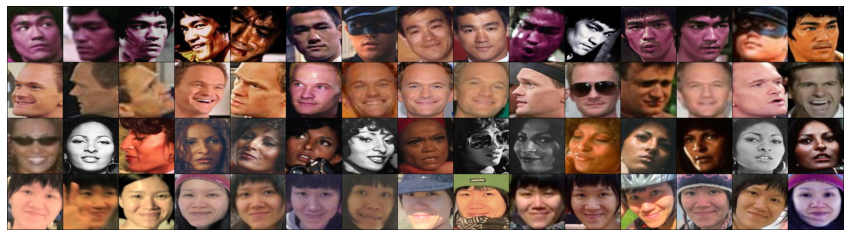

In [17]:
# Crop the images
bruce_tensor, bruce_display = process_images(fname+'/bruce/*.jpg')
neil_tensor, neil_display = process_images(fname+'/neil/*.jpg')
pam_tensor, pam_display = process_images(fname+'/pam/*.jpg')
manyi_tensor, manyi_display = process_images(fname+'/manyi/*.jpg')

tensor_to_display = torch.cat((bruce_display, neil_display, pam_display, manyi_display))

plt.figure(figsize=(15, 15))
plt.imshow(make_grid(tensor_to_display, nrow=15).permute(1, 2, 0))
plt.axis('off')
plt.show()

### Part 3: Embedding with a pretrained network 

We use the pretrained facial recognition model called [FaceNet](https://github.com/timesler/facenet-pytorch) to calculate embeddings for all of our input images.

In [18]:
# Calculate embedding: 512-dimensional normalized vectors
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)
resnet.classify = False
bruce_embeddings = resnet(bruce_tensor.to(device))
neil_embeddings = resnet(neil_tensor.to(device))
pam_embeddings = resnet(pam_tensor.to(device))
manyi_embeddings = resnet(manyi_tensor.to(device))

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [19]:
# Project the 512 dimensions onto a 2D space using Principal Component Analysis (PCA)
embedding_tensor = torch.cat((bruce_embeddings,
                              neil_embeddings,
                              pam_embeddings,
                              manyi_embeddings)).to(device='cpu')

pca = sklearn.decomposition.PCA(n_components=2)
pca_tensor = pca.fit_transform(embedding_tensor.detach().cpu().numpy())

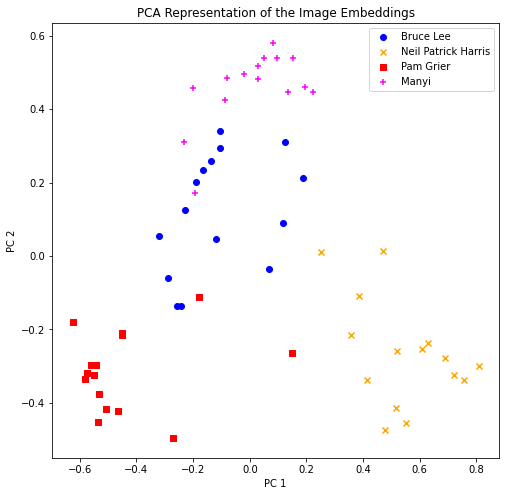

In [20]:
# PCA
num = 15
categs = 4
colors = ['blue', 'orange', 'red', 'magenta']
labels = ['Bruce Lee', 'Neil Patrick Harris', 'Pam Grier', 'Manyi']
markers = ['o', 'x', 's', '+']
plt.figure(figsize=(8, 8))
for i in range(categs):
   plt.scatter(pca_tensor[i*num:(i+1)*num, 0],
               pca_tensor[i*num:(i+1)*num, 1],
               c=colors[i],
               marker=markers[i], label=labels[i])
plt.legend()
plt.title('PCA Representation of the Image Embeddings')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

---
## Section 3: Similarity and dissimilarity measures


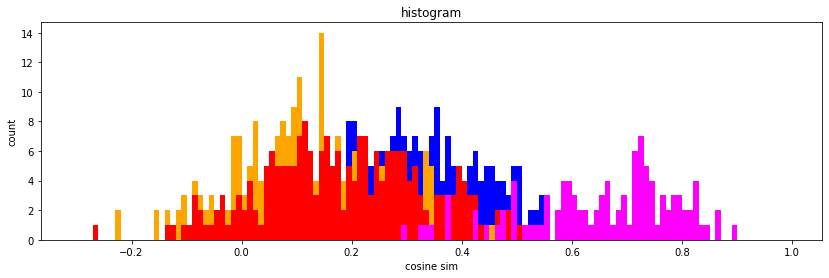

In [21]:
# Similarity using cosine or dot product
# (Since the embedding tensors are normalized, the two are equivalent)

sim_within = []
sim_across = [[],[],[]]
for j in range(15):
    for k in range(j+1,15):
        sim_within.append(np.dot(manyi_embeddings[j,:].detach().numpy(),manyi_embeddings[k,:].detach().numpy()))
        
for j in range(15):
    for k in range(15):
        sim_across[0].append(np.dot(manyi_embeddings[j,:].detach().numpy(),bruce_embeddings[k,:].detach().numpy()))
        sim_across[1].append(np.dot(manyi_embeddings[j,:].detach().numpy(),neil_embeddings[k,:].detach().numpy()))
        sim_across[2].append(np.dot(manyi_embeddings[j,:].detach().numpy(),pam_embeddings[k,:].detach().numpy()))
        
plt.figure(figsize=(14, 4))
for j in range(3):
    plt.hist(sim_across[j],np.arange(-0.3,1,0.01),color=colors[j])
plt.hist(sim_within,np.arange(-0.3,1,0.01),color=colors[3])
plt.title('histogram')
plt.xlabel('cosine sim')
plt.ylabel('count')
plt.show()    

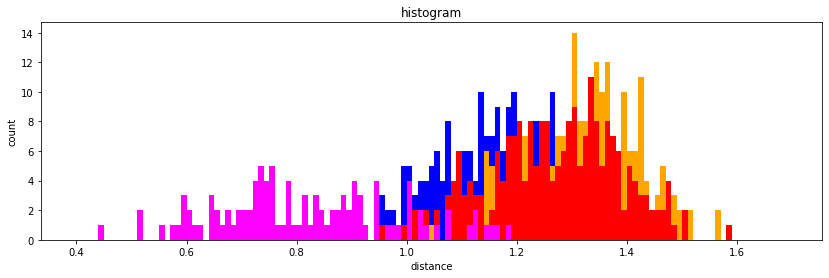

In [22]:
# Dissimilarity using Euclidean distance

dis_within = []
dis_across = [[],[],[]]
for j in range(15):
    for k in range(j+1,15):
        dis_within.append(np.linalg.norm((manyi_embeddings[j,:]-manyi_embeddings[k,:]).detach().numpy()))
        
for j in range(15):
    for k in range(15):
        dis_across[0].append(np.linalg.norm((manyi_embeddings[j,:]-bruce_embeddings[k,:]).detach().numpy()))
        dis_across[1].append(np.linalg.norm((manyi_embeddings[j,:]-neil_embeddings[k,:]).detach().numpy()))
        dis_across[2].append(np.linalg.norm((manyi_embeddings[j,:]-pam_embeddings[k,:]).detach().numpy()))
        
plt.figure(figsize=(14, 4))
for j in range(3):
    plt.hist(dis_across[j],np.arange(0.4,1.7,0.01),color=colors[j])
plt.hist(dis_within,np.arange(0.4,1.7,0.01),color=colors[3])
plt.title('histogram')
plt.xlabel('distance')
plt.ylabel('count')
plt.show()    

## Section 4: Train a ResNet
### Part 1: Data selection

In [23]:
# Download Data

fname = 'images'
url = 'https://github.com/myyim/dataset/raw/main/'+fname+'.zip'
num = 10
nppl = 5

if not os.path.exists(fname):
  print("Data is being downloaded...")
  r = requests.get(url, stream=True)
  z = zipfile.ZipFile(io.BytesIO(r.content))
  z.extractall()
  print("The download has been completed.")
else:
  print("Data has already been downloaded.")

Data is being downloaded...
The download has been completed.


In [24]:
# Crop and save the images
                
def save_cropped(dir_in,dir_out):
    for root, dirs, files in os.walk(dir_in):
        if root == dir_in:
            os.mkdir(dir_out)
            for dir in dirs:
                os.mkdir(dir_out+'/'+dir)
        else:
            _,img = process_images(root+'/*.jpg')
            dir = root.rsplit('/', 1)[-1]
            print('Images of ' + dir + ' are saved.')
            for j in range(img.shape[0]):
                save_image(img[j], './'+dir_out+'/'+dir+'/'+files[j])
                
save_cropped('images','girls')

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Images of karen are saved.
Images of kami are saved.
Images of manyi are saved.
Images of coey are saved.
Images of vicky are saved.


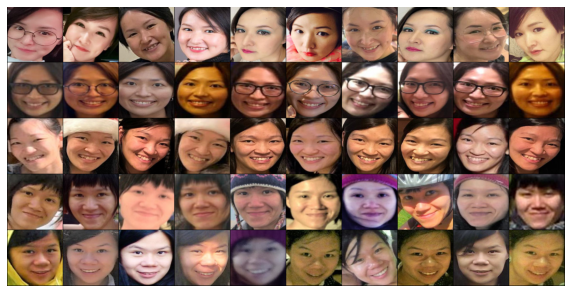

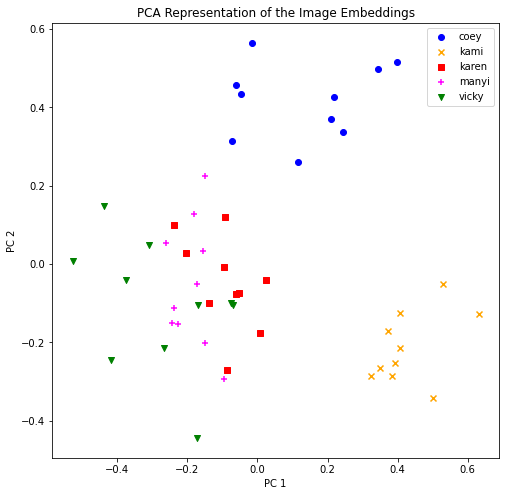

In [25]:
# Display the cropped images

fname = 'girls' # cropped

who = []
images_tensor = []
for root, dirs, _ in os.walk(fname):
    for dirname in sorted(dirs):
        who.append(dirname)
        image_tensor, image_display = process_images(fname + '/' + dirname + '/*.jpg')
        if images_tensor != []:
            images_tensor = torch.cat((images_tensor,image_tensor))
            images_display = torch.cat((images_display,image_display))
        else:
            images_tensor = image_tensor
            images_display = image_display

plt.figure(figsize=(10, 10))
plt.imshow(make_grid(images_display,nrow=num).permute(1, 2, 0))
plt.axis('off')
plt.show()

# Calculate embedding: 512-dimensional normalized vectors
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)
resnet.classify = False
embedding_tensor = resnet(images_tensor.to(device))


# t-SNE
# vector2d = sklearn.manifold.TSNE(n_components=2, learning_rate='auto',
#                    init='random').fit_transform(embedding_tensor.detach().cpu().numpy())

# PCA
pca = sklearn.decomposition.PCA(n_components=2)
vector2d = pca.fit_transform(embedding_tensor.detach().cpu().numpy())
colors = ['blue', 'orange', 'red', 'magenta','green']
markers = ['o', 'x', 's', '+', 'v']
plt.figure(figsize=(8, 8))
for i in range(nppl):
    plt.scatter(vector2d[i*num:(i+1)*num, 0],
                vector2d[i*num:(i+1)*num, 1],
                c=colors[i],marker=markers[i],label=who[i])
plt.legend()
plt.title('PCA Representation of the Image Embeddings')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
# plt.title('t-SNE Representation of the Image Embeddings')
plt.show()

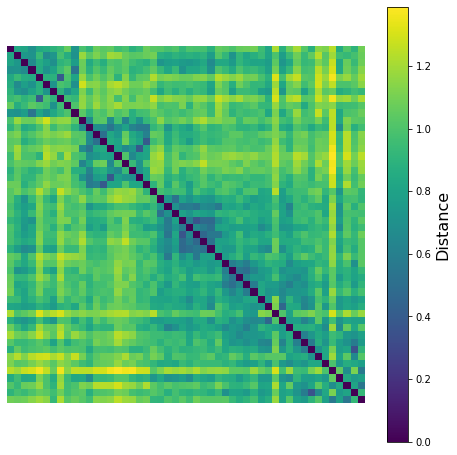

In [26]:
distances = torch.cdist(embedding_tensor, embedding_tensor)

plt.figure(figsize=(8, 8))
plt.imshow(distances.detach().cpu().numpy())
cbar = plt.colorbar()
cbar.set_label('Distance', fontsize=16)
plt.axis('off')
plt.show()

In [27]:
# Define train and test set

trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])

image_dataset = ImageFolder(fname, transform=trans)
# image_loader = torch.utils.data.DataLoader(image_dataset,
#                                           batch_size=nppl*num,
#                                           shuffle=False)

idx = torch.arange(nppl*num)
train_indices = idx[torch.remainder(idx,10)<=7]
test_indices = idx[torch.remainder(idx,10)>7]

image_train_set = torch.utils.data.Subset(image_dataset, train_indices)
image_test_set = torch.utils.data.Subset(image_dataset, test_indices)

image_train_loader = torch.utils.data.DataLoader(image_train_set,
                                                   batch_size=5,
                                                   shuffle=True,)
image_test_loader = torch.utils.data.DataLoader(image_test_set,
                                                  batch_size=5)

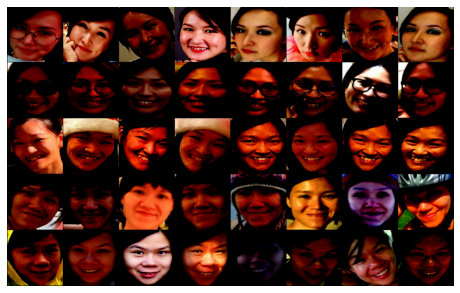

In [28]:
# Train set
train_set = torch.utils.data.Subset(image_dataset, train_indices)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=50,shuffle=False)

dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
plt.figure(figsize=(8, 8))
plt.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
plt.axis('off')
plt.show()

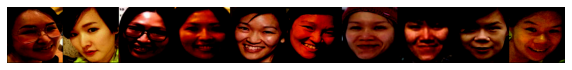

In [29]:
# Test set
test_set = torch.utils.data.Subset(image_dataset, test_indices)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=50,shuffle=False)

dataiter = iter(test_loader)
images, labels = dataiter.next()

# show images
plt.figure(figsize=(10, 10))
plt.imshow(make_grid(images, nrow=10).permute(1, 2, 0))
plt.axis('off')
plt.show()

### Part 2: Fine-tuning a pretrained ResNet

In [30]:
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=nppl
).eval().to(device)

optimizer = torch.optim.Adam(resnet.parameters(), lr=0.0001)
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

print('\n\nInitial')
print('-' * 10)
resnet.eval()
loss_val, metric_val = training.pass_epoch(
    resnet, loss_fn, image_test_loader,
    batch_metrics=metrics, show_running=True, device=device
)
lossfunc = [loss_val]
accfunc = [metric_val['acc']]

epochs = 10
for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet.train()
    training.pass_epoch(
        resnet, loss_fn, image_train_loader, optimizer,
        batch_metrics=metrics, show_running=True, device=device
    )

    resnet.eval()
    loss_val, metric_val = training.pass_epoch(
        resnet, loss_fn, image_test_loader,
        batch_metrics=metrics, show_running=True, device=device
    )
    lossfunc.append(loss_val)
    accfunc.append(metric_val['acc'])
    
lossfunc = torch.stack(lossfunc)
accfunc = torch.stack(accfunc)



Initial
----------
Valid |     2/2    | loss:    1.7758 | fps:    9.1074 | acc:    0.2000   

Epoch 1/10
----------
Train |     8/8    | loss:    1.1990 | fps:    2.8491 | acc:    0.4500   
Valid |     2/2    | loss:    0.6609 | fps:    8.3802 | acc:    1.0000   

Epoch 2/10
----------
Train |     8/8    | loss:    0.4853 | fps:    2.8723 | acc:    0.9000   
Valid |     2/2    | loss:    0.3119 | fps:    8.0077 | acc:    1.0000   

Epoch 3/10
----------
Train |     8/8    | loss:    0.2218 | fps:    2.8082 | acc:    0.9500   
Valid |     2/2    | loss:    0.1900 | fps:    9.0107 | acc:    1.0000   

Epoch 4/10
----------
Train |     8/8    | loss:    0.1989 | fps:    2.8827 | acc:    0.9750   
Valid |     2/2    | loss:    0.1554 | fps:    8.4831 | acc:    1.0000   

Epoch 5/10
----------
Train |     8/8    | loss:    0.1738 | fps:    2.8138 | acc:    0.9750   
Valid |     2/2    | loss:    0.1270 | fps:    8.9340 | acc:    1.0000   

Epoch 6/10
----------
Train |     8/8    | loss: 

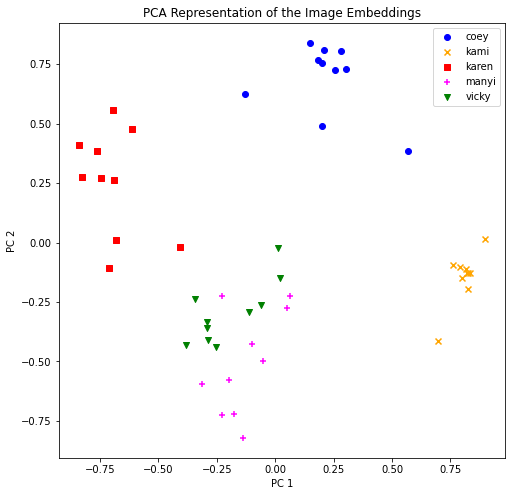

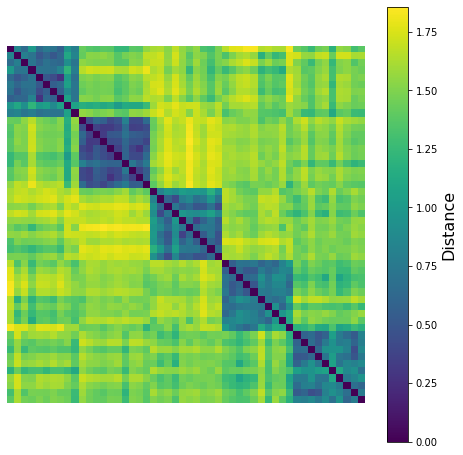

In [31]:
# embeddings after training
resnet.classify = False
embedding_tensor = resnet(images_tensor.to(device))

# PCA
pca = sklearn.decomposition.PCA(n_components=2)
vector2d = pca.fit_transform(embedding_tensor.detach().cpu().numpy())
colors = ['blue', 'orange', 'red', 'magenta','green']
markers = ['o', 'x', 's', '+', 'v']
plt.figure(figsize=(8, 8))
for i in range(nppl):
   plt.scatter(vector2d[i*num:(i+1)*num, 0],
               vector2d[i*num:(i+1)*num, 1],
               c=colors[i],
               marker=markers[i], label=who[i])
plt.legend()
plt.title('PCA Representation of the Image Embeddings')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

distances = torch.cdist(embedding_tensor, embedding_tensor)
plt.figure(figsize=(8, 8))
plt.imshow(distances.detach().cpu().numpy())
cbar = plt.colorbar()
cbar.set_label('Distance', fontsize=16)
plt.axis('off')
plt.show()

### Part 3: Test with new images

In [32]:
def sigmoid(s):
    return np.exp(s)/(1+np.exp(s))

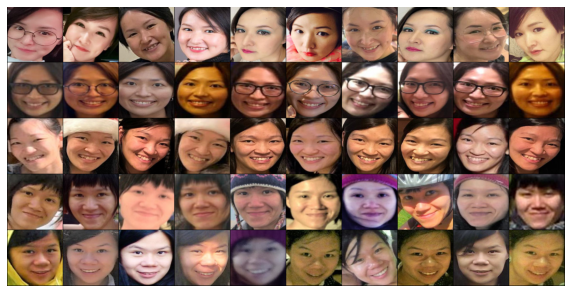

Prediction from the trained network (chance level = 20.0%)
1 coey (99.6941%)
2 coey (99.36343%)
3 coey (99.32384%)
4 coey (99.42493%)
5 coey (99.606476%)
6 coey (99.559715%)
7 coey (99.69852%)
8 coey (99.45222%)
9 coey (84.14476%)
10 coey (96.7325%)
11 kami (99.8221%)
12 kami (99.84367%)
13 kami (99.58787%)
14 kami (99.859474%)
15 kami (99.81402%)
16 kami (99.80778%)
17 kami (97.29944%)
18 kami (99.68621%)
19 kami (99.53437%)
20 kami (99.697754%)
21 karen (96.73037%)
22 karen (99.932655%)
23 karen (98.92118%)
24 karen (99.73001%)
25 karen (98.43354%)
26 karen (97.20624%)
27 karen (99.50838%)
28 karen (99.05898%)
29 karen (92.8546%)
30 karen (98.79937%)
31 manyi (99.12299%)
32 manyi (98.782906%)
33 manyi (97.26757%)
34 manyi (99.16928%)
35 manyi (99.08258%)
36 manyi (99.71132%)
37 manyi (99.24658%)
38 manyi (99.07163%)
39 manyi (97.27952%)
40 manyi (95.94341%)
41 vicky (99.86107%)
42 vicky (99.04045%)
43 vicky (99.47703%)
44 vicky (98.97204%)
45 vicky (99.365845%)
46 vicky (89.44965%)
4

In [33]:
# Verify with original images

plt.figure(figsize=(10, 10))
plt.imshow(make_grid(images_display,nrow=num).permute(1, 2, 0))
plt.axis('off')
plt.show()

resnet.classify = True
logit = resnet(images_tensor.to(device))

print('Prediction from the trained network (chance level = '+str(100/nppl)+'%)')
val, ind = torch.max(logit,1)
prob = sigmoid(val.detach().numpy())*100
for j in range(50):
    print(str(j+1) + ' ' + who[ind[j]] + ' (' + str(prob[j]) + '%)')

Data has already been downloaded.


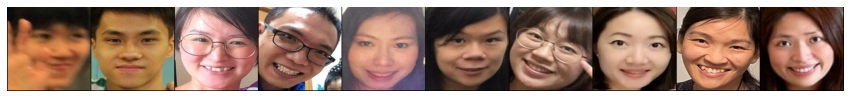

Prediction from the trained network (chance level = 20.0%)
1 manyi (96.4525%)
2 vicky (67.62897%)
3 coey (96.64615%)
4 coey (79.80396%)
5 vicky (87.737045%)
6 vicky (97.495285%)
7 kami (85.87633%)
8 coey (80.653206%)
9 karen (98.05333%)
10 kami (98.23064%)


In [37]:
import requests, zipfile, io, os

fname = 'testfaces'
url = 'https://github.com/myyim/dataset/raw/main/'+fname+'.zip'

if not os.path.exists(fname):
  print("Data is being downloaded...")
  r = requests.get(url, stream=True)
  z = zipfile.ZipFile(io.BytesIO(r.content))
  z.extractall()
  print("The download has been completed.")
else:
  print("Data has already been downloaded.")

num = 10
testfaces_tensor, testfaces_display = process_images(fname +'/*.jpg')
plt.figure(figsize=(15, 15))
plt.imshow(make_grid(testfaces_display,nrow=num).permute(1, 2, 0))
plt.axis('off')
plt.show()

resnet.classify = True
logit = resnet(testfaces_tensor.to(device))

print('Prediction from the trained network (chance level = '+str(100/nppl)+'%)')
val, ind = torch.max(logit,1)
prob = sigmoid(val.detach().numpy())*100
for j in range(num):
    print(str(j+1) + ' ' + who[ind[j]] + ' (' + str(prob[j]) + '%)')

### Part 4: Train from scratch

In [35]:
resnet2 = InceptionResnetV1(
    classify=True,
    pretrained=None,
    num_classes=nppl
)

optimizer = torch.optim.Adam(resnet2.parameters(), lr=0.0001)
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

print('\n\nInitial')
print('-' * 10)
resnet2.eval()
loss_val, metric_val = training.pass_epoch(
    resnet2, loss_fn, image_test_loader,
    batch_metrics=metrics, show_running=True, device=device
)
lossfunc2 = [loss_val]
accfunc2 = [metric_val['acc']]

epochs = 20
for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet2.train()
    training.pass_epoch(
        resnet2, loss_fn, image_train_loader, optimizer,
        batch_metrics=metrics, show_running=True, device=device
    )

    resnet2.eval()
    loss_val, metric_val = training.pass_epoch(
        resnet2, loss_fn, image_test_loader,
        batch_metrics=metrics, show_running=True, device=device,
    )
    lossfunc2.append(loss_val)
    accfunc2.append(metric_val['acc'])
    
lossfunc2 = torch.stack(lossfunc2)
accfunc2 = torch.stack(accfunc2)



Initial
----------
Valid |     2/2    | loss:    1.6097 | fps:    9.5989 | acc:    0.2000   

Epoch 1/20
----------
Train |     8/8    | loss:    1.7542 | fps:    2.9344 | acc:    0.2500   
Valid |     2/2    | loss:    1.6699 | fps:    9.4916 | acc:    0.2000   

Epoch 2/20
----------
Train |     8/8    | loss:    1.2497 | fps:    2.8258 | acc:    0.4500   
Valid |     2/2    | loss:    1.8248 | fps:    9.4238 | acc:    0.2000   

Epoch 3/20
----------
Train |     8/8    | loss:    1.1087 | fps:    2.8909 | acc:    0.5750   
Valid |     2/2    | loss:    1.8975 | fps:    9.5163 | acc:    0.2000   

Epoch 4/20
----------
Train |     8/8    | loss:    0.9807 | fps:    2.8474 | acc:    0.6500   
Valid |     2/2    | loss:    1.6645 | fps:    9.4200 | acc:    0.3000   

Epoch 5/20
----------
Train |     8/8    | loss:    1.0403 | fps:    2.9368 | acc:    0.6750   
Valid |     2/2    | loss:    1.2956 | fps:    9.6304 | acc:    0.3000   

Epoch 6/20
----------
Train |     8/8    | loss: 

Text(0, 0.5, 'accuracy')

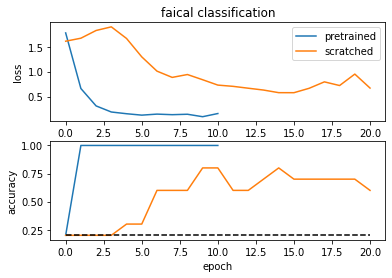

In [36]:
# Comparision
plt.figure()
plt.subplot(211)
plt.plot(lossfunc,label='pretrained')
plt.plot(lossfunc2,label='scratched')
plt.ylabel('loss')
plt.legend()
plt.title('faical classification')
plt.subplot(212)
plt.plot(accfunc,label='pretrained')
plt.plot(accfunc2,label='scratched')
plt.plot([0,epochs],torch.ones(2)/nppl,'k--')
plt.xlabel('epoch')
plt.ylabel('accuracy')

In [38]:
# Verify with original images

resnet.classify = True
logit = resnet2(images_tensor.to(device))

print('Prediction from the trained network (chance level = '+str(100/nppl)+'%)')
val, ind = torch.max(logit,1)
prob = sigmoid(val.detach().numpy())*100
for j in range(50):
    print(str(j+1) + ' ' + who[ind[j]] + ' (' + str(prob[j]) + '%)')

Prediction from the trained network (chance level = 20.0%)
1 coey (99.78977%)
2 coey (93.29323%)
3 coey (95.65145%)
4 coey (99.85737%)
5 coey (99.97704%)
6 coey (99.23108%)
7 coey (97.188995%)
8 coey (99.87145%)
9 manyi (76.130905%)
10 coey (90.26975%)
11 kami (99.5509%)
12 kami (97.09722%)
13 kami (97.37103%)
14 kami (99.47917%)
15 kami (98.328606%)
16 kami (99.74977%)
17 kami (98.98762%)
18 kami (99.36476%)
19 kami (98.85721%)
20 kami (99.786194%)
21 karen (96.119484%)
22 karen (99.727806%)
23 karen (99.96738%)
24 karen (99.26004%)
25 karen (99.94879%)
26 karen (99.77081%)
27 karen (99.991646%)
28 karen (99.91651%)
29 karen (94.54972%)
30 karen (99.84193%)
31 manyi (98.26433%)
32 manyi (96.59538%)
33 manyi (99.883965%)
34 manyi (97.44068%)
35 manyi (97.01%)
36 manyi (99.67099%)
37 manyi (99.92794%)
38 manyi (99.77658%)
39 manyi (66.6255%)
40 karen (94.56974%)
41 vicky (98.401436%)
42 vicky (86.39015%)
43 vicky (96.61141%)
44 vicky (93.29761%)
45 vicky (99.920746%)
46 vicky (99.999115